In [1]:
import warnings
warnings.filterwarnings("ignore")

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from arch import arch_model
from hmmlearn.hmm import GaussianHMM

Model is not converging.  Current: 134.86049378108157 is not greater than 143.9040955754228. Delta is -9.043601794341214


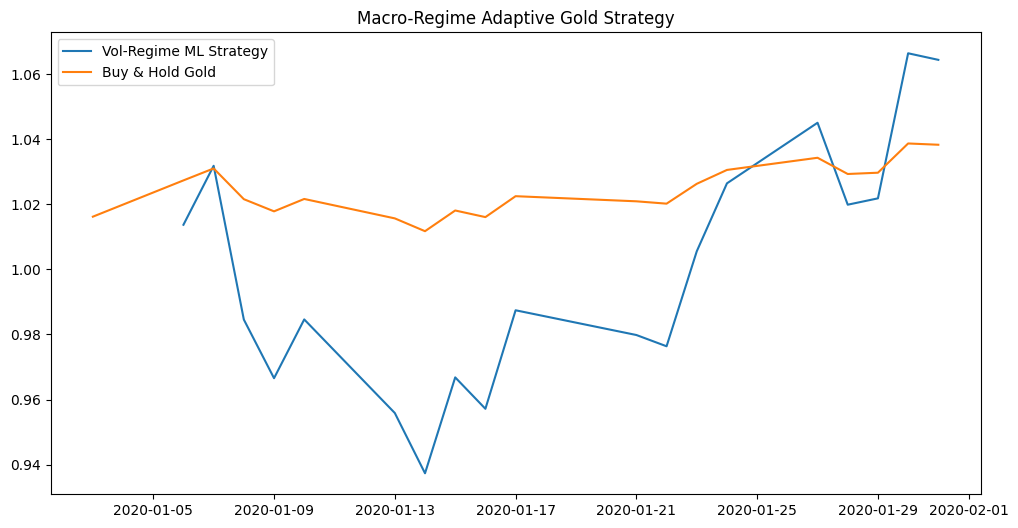

CAGR Strategy: 119.55%
CAGR Buy & Hold: 60.59%
Sharpe Strategy: 2.34
Sharpe Buy & Hold: 4.84


In [2]:


############################################
# 1) DOWNLOAD GOLD DATA
############################################
data = yf.download("GC=F", start="2020-01-01", progress=False)

# Use Close column and rename
prices = data[["Close"]].rename(columns={"Close":"GOLD"}).dropna()

############################################
# 2) RETURNS
############################################
prices["ret"] = prices["GOLD"].pct_change()
prices = prices.dropna()  # drop first NaN

############################################
# 3) FIT GARCH(1,1) FOR VOLATILITY FORECAST
############################################
# GARCH expects returns in percentage
am = arch_model(prices["ret"]*100, vol="Garch", p=1, q=1)
res = am.fit(disp="off")

# Use conditional volatility as forecast
prices["garch_vol"] = res.conditional_volatility / 100  # convert back to decimal

############################################
# 4) HMM REGIME DETECTION
############################################
X = prices[["ret", "garch_vol"]].dropna()

hmm = GaussianHMM(n_components=2, covariance_type="full", n_iter=200, random_state=42)
hmm.fit(X)

prices.loc[X.index, "regime"] = hmm.predict(X)

# Map regimes: lower vol -> risk-on, higher vol -> risk-off
regime_vol = prices.groupby("regime")["garch_vol"].mean()
low_vol_regime = regime_vol.idxmin()
high_vol_regime = regime_vol.idxmax()

prices["regime_label"] = np.where(prices["regime"]==low_vol_regime, "RISK-ON", "RISK-OFF")

############################################
# 5) DYNAMIC POSITION SIZING
############################################
# Inverse-volatility sizing
inv_vol = 1 / prices["garch_vol"]
inv_vol = inv_vol.clip(upper=5)  # cap extreme exposures

# Reduce position in risk-off regime
position = inv_vol.copy()
position[prices["regime"]==high_vol_regime] *= 0.25

prices["position"] = position

############################################
# 6) STRATEGY RETURNS
############################################
# Shift position by 1 to avoid lookahead bias
prices["strategy_ret"] = prices["position"].shift(1) * prices["ret"]
prices["buy_hold_ret"] = prices["ret"]

prices["equity_curve_strategy"] = (1 + prices["strategy_ret"]).cumprod()
prices["equity_curve_buyhold"] = (1 + prices["buy_hold_ret"]).cumprod()

############################################
# 7) PLOT RESULTS
############################################
plt.figure(figsize=(12,6))
plt.plot(prices["equity_curve_strategy"], label="Vol-Regime ML Strategy")
plt.plot(prices["equity_curve_buyhold"], label="Buy & Hold Gold")
plt.legend()
plt.title("Macro-Regime Adaptive Gold Strategy")
plt.show()

############################################
# 8) PERFORMANCE METRICS
############################################
def calc_metrics(df):
    daily_ret = df["strategy_ret"]
    buy_hold = df["buy_hold_ret"]
    cagr_strategy = df["equity_curve_strategy"].iloc[-1]**(252/len(df)) - 1
    cagr_buyhold = df["equity_curve_buyhold"].iloc[-1]**(252/len(df)) - 1
    sharpe_strategy = np.sqrt(252) * daily_ret.mean() / daily_ret.std()
    sharpe_buyhold = np.sqrt(252) * buy_hold.mean() / buy_hold.std()
    return cagr_strategy, cagr_buyhold, sharpe_strategy, sharpe_buyhold

cagr_s, cagr_b, sharpe_s, sharpe_b = calc_metrics(prices)
print(f"CAGR Strategy: {cagr_s:.2%}")
print(f"CAGR Buy & Hold: {cagr_b:.2%}")
print(f"Sharpe Strategy: {sharpe_s:.2f}")
print(f"Sharpe Buy & Hold: {sharpe_b:.2f}")


Model is not converging.  Current: 134.86049378108157 is not greater than 143.9040955754228. Delta is -9.043601794341214


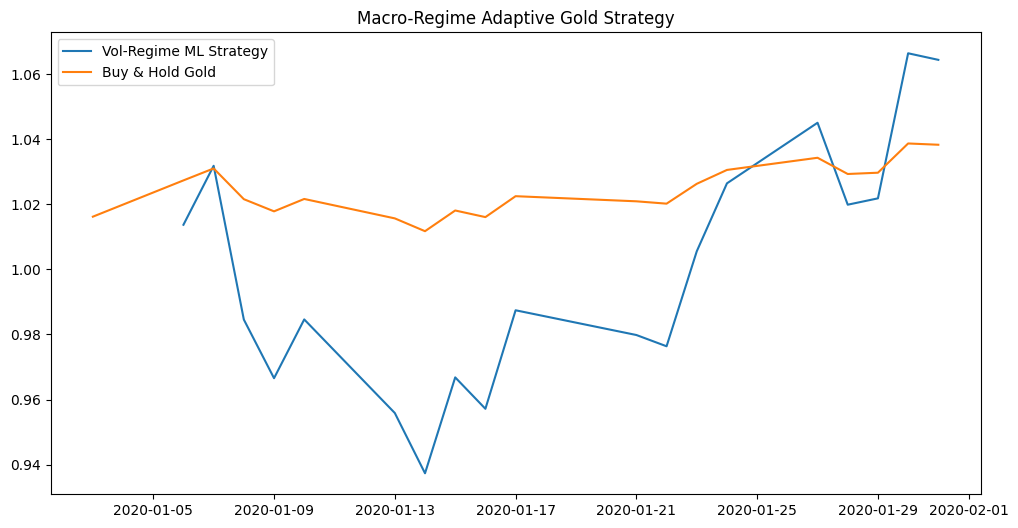

In [2]:
data = yf.download('GC=F', start= "2020-01-01", progress=False)
prices = data[['Close']].rename(columns = {'Close': 'Gold_Close'}).dropna()
prices['ret'] = prices['Gold_Close'].pct_change()
prices = prices.dropna()

#Garch Model
am = arch_model(prices['ret']*100, vol='Garch', p=1, q=1 )
rets = am.fit(disp = 'off')
prices['garch_vol'] = rets.conditional_volatility / 100

#HMM Model:
X = prices[['ret', 'garch_vol']].dropna()
hmm = GaussianHMM(n_components= 2, covariance_type='full', n_iter= 200, random_state=42)
hmm.fit(X)

prices.loc[X.index, 'regime'] = hmm.predict(X)

regime_vol = prices.groupby('regime')['garch_vol'].mean()
low_vol_regime = regime_vol.idxmin()
high_vol_regime = regime_vol.idxmax()

prices["regime_label"] = np.where(prices["regime"]==low_vol_regime, "RISK-ON", "RISK-OFF")

inv_vol = 1/prices['garch_vol'] #if the market is less volatile then max leverage
inv_vol = inv_vol.clip(upper = 5) # if the market is more volatile the max limit to buy will be 5

#reduce the position in risk-off regime
position = inv_vol.copy()
position[prices['regime'] == high_vol_regime] *= 0.25

prices['position'] = position

prices['strategy_return'] = prices['position'].shift(1) * prices['ret']
prices['buy_hold_ret'] = prices['ret']

prices['equity_curve_strategy'] = (1 + prices['strategy_return']).cumprod()
prices['equity_curve_buyhold'] = (1 + prices['buy_hold_ret']).cumprod()

plt.figure(figsize=(12,6))
plt.plot(prices["equity_curve_strategy"], label="Vol-Regime ML Strategy")
plt.plot(prices["equity_curve_buyhold"], label="Buy & Hold Gold")
plt.legend()
plt.title("Macro-Regime Adaptive Gold Strategy")
plt.show()

def calc_metrics(df):
    strategy_return = df['strategy_return']
    buy_hold = df['buy_hold_ret']
    cagr_strategy = df['equity_curve_strategy'].iloc[-1]**(252/len(df)) -1
    cagr_buy_hold = df['equity_curve_buyhold'].iloc[-1]**(252/len(df)) -1
    sharpe_strategy = np.sqrt(252) * strategy_return.mean() / strategy_return.std()
    sharpe_buy_hold = np.sqrt(252) * buy_hold.mean() / buy_hold.std()
    
    